**<h3 align="center">Deep Learning - Project</h3>**
# **<h3 align="center">Concatenate </h3>**
**Group members:**<br>Alexandra Pinto - 20211599@novaims.unl.pt - 20211599<br>
Ilona Nacu - 20211602@novaims.unl.pt - 20211602<br>
Francisco Farinha - 20211550@novaims.unl.pt - 20211550<br>
João Barradas - 20211590@novaims.unl.pt - 20211590<br>
Rafael Proença  - 2021681@novaims.unl.pt - 2021681<br>


# Table of Contents
* [1. Imports](#chapter1)
    * [1.1. Libraries](#section_1_1)
    * [1.2. Datasets](#section_1_2)
* [2. Concatenate](#chapter2)
    * [2.1. First Model](#section_2_1)
        * [2.1.1. Modeling](#sub_section_2_1_1)
        * [2.1.2. Check Performance](#sub_section_2_1_2)        
        * [2.1.3. Observations](#sub_section_2_1_3)
    * [2.2. Sencond Model](#section_2_2)
        * [2.2.1. Modeling](#sub_section_2_2_1)
        * [2.2.2. Check Performance](#sub_section_2_2_2)        
        * [2.2.3. Observations](#sub_section_2_2_3)
    * [2.3. Third Model](#section_2_3)
        * [2.3.1. Modeling](#sub_section_2_3_1)
        * [2.3.2. Check Performance](#sub_section_2_3_2)        
        * [2.3.3. Observations](#sub_section_2_3_3)
    * [2.4. Fourth Model](#section_2_4)
        * [2.4.1. Modeling](#sub_section_2_4_1)
        * [2.4.2. Check Performance](#sub_section_2_4_2)        
* [3. Comparing the Best Models](#chapter3)


Connect drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1.Imports <a class="anchor" id="chapter1"></a>

## 1.1. Libraries <a class="anchor" id="section_1_1"></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, f1_score

import tensorflow as tf
from tensorflow import keras
from keras.models import load_model, Model
from keras.layers import Input, Concatenate, Dense
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import plot_model
from keras import regularizers
from keras.regularizers import l2
from keras.optimizers import Adam, RMSprop

#To evaluate the Ensemble Model
import sys
sys.path.append('/content/drive/MyDrive/Deep Learning/Project - 80%')
from utils import evaluate_classification_report_with_matrix
from utils import plot_loss, get_f1_model


## 1.2. Datasets <a class="anchor" id="section_1_2"></a>

In this topic we will load the data needed in concatenate, which is the data from metadata used in notebook 3, and the data concerning the preprocessed images from the convolutional neural network in notebook 2.



In [ ]:
# Read the CSV file into a DataFrame
X_train_tabular = pd.read_csv("/content/drive/MyDrive/Deep Learning/Project - 80%/Data/X_Data/X_train_metadata.csv")
X_val_tabular = pd.read_csv("/content/drive/MyDrive/Deep Learning/Project - 80%/Data/X_Data/X_val_metadata.csv")
X_test_tabular = pd.read_csv("/content/drive/MyDrive/Deep Learning/Project - 80%/Data/X_Data/X_test_metadata.csv")

Now for the image data.

In [ ]:
X_train_image_10 = np.load('/content/drive/MyDrive/Deep Learning/Project - 80%/Data/X_Data/X_train_preproc_image_10.npy')
X_val_image_10 = np.load('/content/drive/MyDrive/Deep Learning/Project - 80%/Data/X_Data/X_val_preproc_image_10.npy')
X_test_image_10 = np.load('/content/drive/MyDrive/Deep Learning/Project - 80%/Data/X_Data/X_test_preproc_image_10.npy')

Now we load the y data.

In [ ]:
y_train_categorical = np.load('/content/drive/MyDrive/Deep Learning/Project - 80%/Data/Y_Data/y_train_categorical.npy')
y_val_categorical = np.load('/content/drive/MyDrive/Deep Learning/Project - 80%/Data/Y_Data/y_val_categorical.npy')
y_test_categorical = np.load('/content/drive/MyDrive/Deep Learning/Project - 80%/Data/Y_Data/y_test_categorical.npy')

In [ ]:
print(X_train_tabular.shape)  # Check the shape of tabular data
print(X_train_image_10.shape)    # Check the shape of image data
print(y_train_categorical.shape ) #Check the shape of y

(6384, 24)
(6384, 40, 60, 3)
(6384, 7)


In [ ]:
print(y_train_categorical.shape , "\n")
print(y_val_categorical.shape , "\n")

(6384, 7) 

(1127, 7) 



# 2.Concatenate <a class="anchor" id="*chapter2*"></a>

Combining tabular and image data in neural networks often involves using the Functional API, as mentioned in classes, in particular in the 6th powerpoint of Theoretical classes. Researching about Functional API we arrive into a crucial function called *Concatenate*. It's a method to merge both types of data, allowing a neural network to learn from both sources simultaneously. This approach enables harnessing the power of Convolutional Neural Networks (CNNs) for images and traditional Neural Networks for tabular data within a single model. <br>
To use this we will need the tabular data, image data and the y_train, already load in before steps. <br>
We will also need the layers from the best CNN and NN models. <br>
The first step is uploading the best models:


In [ ]:
tabular_model_1 = load_model("/content/drive/MyDrive/Deep Learning/Project - 80%/Models/Attempts/metadata_model_:(.keras", compile=False)
image_model_1 = load_model("/content/drive/MyDrive/Deep Learning/Project - 80%/Models/Attempts/fourth_cnn_weigths.keras", compile=False)

In [ ]:
#Creating two new models uing the inputs and outputs of the best model concerning tabular and
tabular_model_1_layer = Model(inputs=tabular_model_1.input, outputs=tabular_model_1.layers[-2].output)
image_model_1_layer = Model(inputs=image_model_1.input, outputs=image_model_1.layers[-2].output)

#This is needed to achieve a clear differentiation between the layers originating from the tabular and image models
for layer in tabular_model_1_layer.layers:
    layer._name = layer.name + '_tabular'

for layer in image_model_1_layer.layers:
    layer._name = layer.name + '_image'

## 2.1. First Model <a class="anchor" id="section_2_1"></a>

---



To begin we start with a very simple model, with no callbacks nor class weights.

### 2.1.1 Modeling <a class="anchor" id="sub_section_2_1_1"></a>

In [ ]:
x = keras.layers.concatenate([tabular_model_1_layer.output,
                        image_model_1_layer.output])

x = Dense(50, activation='relu', name='dense_hidden_final')(x)

last_layer = Dense(7, activation='softmax')(x)


ensemble_model = keras.Model(inputs=[tabular_model_1_layer.input,
                            image_model_1_layer.input],
                    outputs=[last_layer])

ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

ensemble_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9_image (InputLayer)  [(None, 40, 60, 3)]          0         []                            
                                                                                                  
 conv2d_30_image (Conv2D)    (None, 40, 60, 40)           1120      ['input_9_image[0][0]']       
                                                                                                  
 conv2d_31_image (Conv2D)    (None, 40, 60, 40)           14440     ['conv2d_30_image[0][0]']     
                                                                                                  
 average_pooling2d_6_image   (None, 13, 20, 40)           0         ['conv2d_31_image[0][0]']     
 (AveragePooling2D)                                                                         

In [ ]:
history = ensemble_model.fit(
    [X_train_tabular, X_train_image_10], y_train_categorical,
    epochs=40, batch_size=200, validation_data=([X_val_tabular, X_val_image_10], y_val_categorical)
)

Epoch 1/40
32/32 [==============================] - 98s 3s/step - loss: 19.2673 - accuracy: 0.6812 - val_loss: 7.1545 - val_accuracy: 0.8146
Epoch 2/40
32/32 [==============================] - 99s 3s/step - loss: 3.7126 - accuracy: 0.8180 - val_loss: 1.8091 - val_accuracy: 0.8305
Epoch 3/40
32/32 [==============================] - 88s 3s/step - loss: 1.1803 - accuracy: 0.8460 - val_loss: 0.8379 - val_accuracy: 0.8509
Epoch 4/40
32/32 [==============================] - 81s 3s/step - loss: 0.7067 - accuracy: 0.8568 - val_loss: 0.6202 - val_accuracy: 0.8598
Epoch 5/40
32/32 [==============================] - 79s 2s/step - loss: 0.5996 - accuracy: 0.8614 - val_loss: 0.5935 - val_accuracy: 0.8527
Epoch 6/40
32/32 [==============================] - 80s 3s/step - loss: 0.5476 - accuracy: 0.8717 - val_loss: 0.5337 - val_accuracy: 0.8589
Epoch 7/40
32/32 [==============================] - 80s 3s/step - loss: 0.5135 - accuracy: 0.8756 - val_loss: 0.5239 - val_accuracy: 0.8651
Epoch 8/40
32/32 [=

### 2.1.2. Check Performance <a class="anchor" id="sub_section_2_1_2"></a>

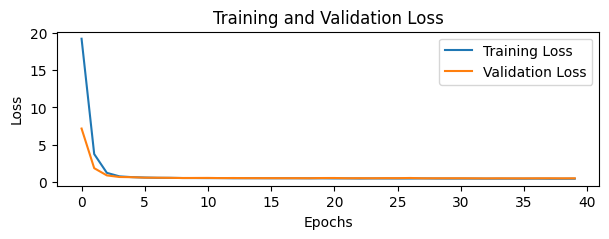

In [ ]:
plot_loss(history)

In [ ]:
evaluate_classification_report_with_matrix(ensemble_model, [X_train_tabular, X_train_image_10], y_train_categorical, matrix=False)

200/200 [==============================] - 21s 103ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.62      0.65       208
           1       0.78      0.80      0.79       327
           2       0.67      0.83      0.74       700
           3       0.89      0.81      0.85        73
           4       0.98      1.00      0.99       710
           5       0.97      0.94      0.95      4275
           6       0.66      0.45      0.54        91

    accuracy                           0.91      6384
   macro avg       0.81      0.78      0.79      6384
weighted avg       0.91      0.91      0.91      6384



36/36 [==============================] - 3s 87ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.51      0.56        37
           1       0.72      0.79      0.75        58
           2       0.60      0.71      0.65       124
           3       1.00      0.77      0.87        13
           4       1.00      1.00      1.00       125
           5       0.95      0.93      0.94       754
           6       0.42      0.31      0.36        16

    accuracy                           0.88      1127
   macro avg       0.76      0.72      0.73      1127
weighted avg       0.89      0.88      0.88      1127



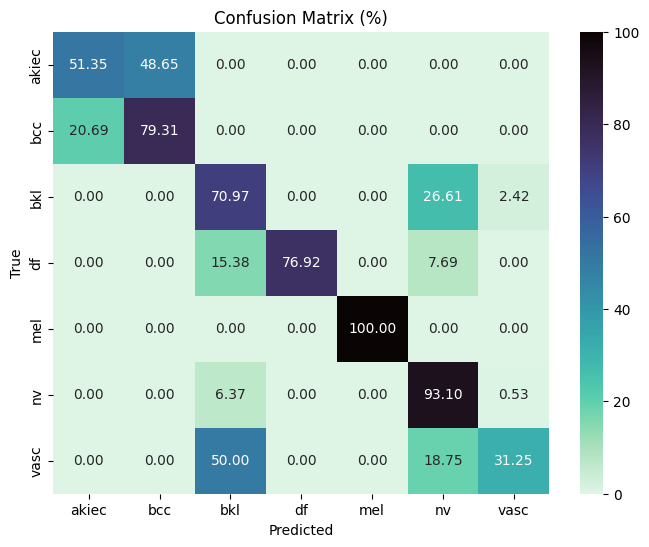

In [ ]:
evaluate_classification_report_with_matrix(ensemble_model, [X_val_tabular, X_val_image_10], y_val_categorical)

79/79 [==============================] - 7s 87ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.50      0.55        82
           1       0.74      0.76      0.75       129
           2       0.60      0.76      0.67       275
           3       0.70      0.48      0.57        29
           4       0.97      1.00      0.98       278
           5       0.95      0.92      0.94      1676
           6       0.17      0.11      0.14        35

    accuracy                           0.88      2504
   macro avg       0.68      0.65      0.66      2504
weighted avg       0.88      0.88      0.88      2504



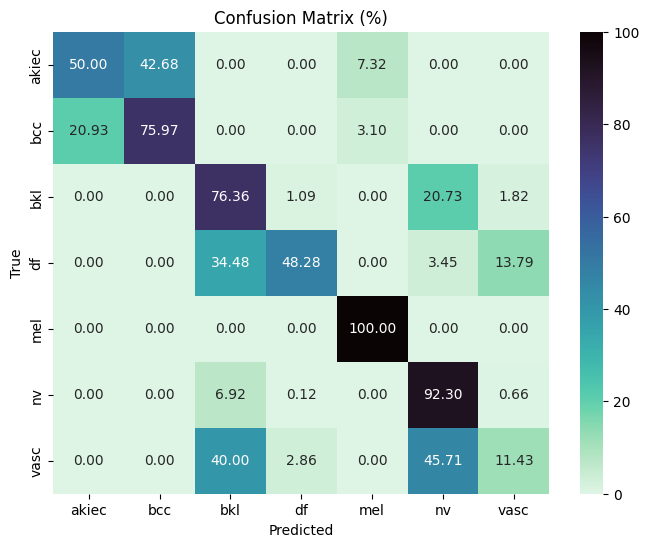

In [ ]:
evaluate_classification_report_with_matrix(ensemble_model, [X_test_tabular, X_test_image_10], y_test_categorical)

### 2.1.3. Observations <a class="anchor" id="sub_section_2_1_3"></a>



> The model performs very good for a first try. Despite this, we have notice that the class 6 is being poorly predicted, for this motive, we will try to add class_weigths, similarly to notebook 3.

## 2.2. Second Model <a class="anchor" id="section_2_2"></a>
---

As mentioned in previous notebooks, our data is unbalanced, for this motive we define class_weights, and test model performance with them.

In [ ]:
#Defining the balanced class weights
y_integers = np.argmax(y_train_categorical, axis=1)
class_weights = compute_class_weight('balanced', classes= np.unique(y_integers), y= y_integers)
d_class_weights = dict(enumerate(class_weights))

In [ ]:
d_class_weights

{0: 4.384615384615385,
 1: 2.7889908256880735,
 2: 1.302857142857143,
 3: 12.493150684931507,
 4: 1.2845070422535212,
 5: 0.21333333333333335,
 6: 10.021978021978022}

### 2.2.1 Modeling <a class="anchor" id="sub_section_2_2_1"></a>

Attempting to introduce balanced class weights, to see if it helps with model performance.

In [ ]:
concatenate_2 = keras.layers.concatenate([tabular_model_1_layer.output,
                        image_model_1_layer.output])

concatenate_2 = Dense(50, activation='relu', name='dense_hidden_final')(concatenate_2)

# Output layer for the ensemble model
output_2 = Dense(7, activation='softmax')(concatenate_2)  # Assuming 7 classes for output

ensemble_model_2 = keras.Model(inputs=[tabular_model_1_layer.input,
                            image_model_1_layer.input],
                    outputs=[output_2])

# Compile the ensemble model
ensemble_model_2.compile(optimizer=Adam(learning_rate = 0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_2 = ensemble_model_2.fit(
    [X_train_tabular, X_train_image_10], y_train_categorical,
    epochs=50, batch_size=200, validation_data=([X_val_tabular, X_val_image_10], y_val_categorical)
    ,class_weight=d_class_weights)

Epoch 1/50
32/32 [==============================] - 82s 2s/step - loss: 1.8902 - accuracy: 0.4027 - val_loss: 1.0878 - val_accuracy: 0.7143
Epoch 2/50
32/32 [==============================] - 78s 2s/step - loss: 1.3994 - accuracy: 0.6416 - val_loss: 0.8606 - val_accuracy: 0.6442
Epoch 3/50
32/32 [==============================] - 81s 3s/step - loss: 1.0844 - accuracy: 0.6858 - val_loss: 0.7474 - val_accuracy: 0.6877
Epoch 4/50
32/32 [==============================] - 76s 2s/step - loss: 0.9115 - accuracy: 0.7116 - val_loss: 0.6672 - val_accuracy: 0.7214
Epoch 5/50
32/32 [==============================] - 80s 2s/step - loss: 0.8204 - accuracy: 0.7262 - val_loss: 0.6289 - val_accuracy: 0.7338
Epoch 6/50
32/32 [==============================] - 78s 2s/step - loss: 0.7420 - accuracy: 0.7511 - val_loss: 0.5509 - val_accuracy: 0.7613
Epoch 7/50
32/32 [==============================] - 79s 2s/step - loss: 0.6998 - accuracy: 0.7473 - val_loss: 0.5253 - val_accuracy: 0.7799
Epoch 8/50
32/32 [==

### 2.2.2. Check Performance <a class="anchor" id="sub_section_2_2_2"></a>

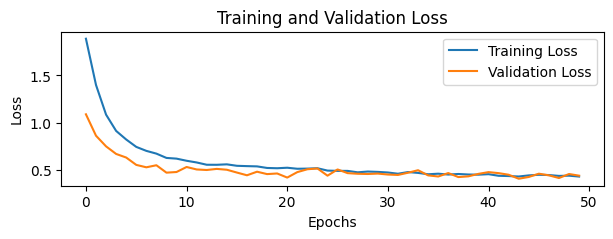

In [ ]:
plot_loss(history_2)

In [ ]:
evaluate_classification_report_with_matrix(ensemble_model_2, [X_train_tabular, X_train_image_10],y_train_categorical, matrix = False)

200/200 [==============================] - 21s 107ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.78      0.71       208
           1       0.80      0.74      0.77       327
           2       0.54      0.84      0.66       700
           3       0.46      0.99      0.63        73
           4       1.00      0.97      0.99       710
           5       0.99      0.84      0.91      4275
           6       0.28      0.82      0.42        91

    accuracy                           0.85      6384
   macro avg       0.67      0.85      0.73      6384
weighted avg       0.90      0.85      0.87      6384



36/36 [==============================] - 3s 88ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.73      0.66        37
           1       0.74      0.69      0.71        58
           2       0.51      0.77      0.61       124
           3       0.41      0.92      0.57        13
           4       1.00      0.97      0.98       125
           5       0.98      0.84      0.90       754
           6       0.29      0.75      0.41        16

    accuracy                           0.83      1127
   macro avg       0.65      0.81      0.69      1127
weighted avg       0.89      0.83      0.85      1127



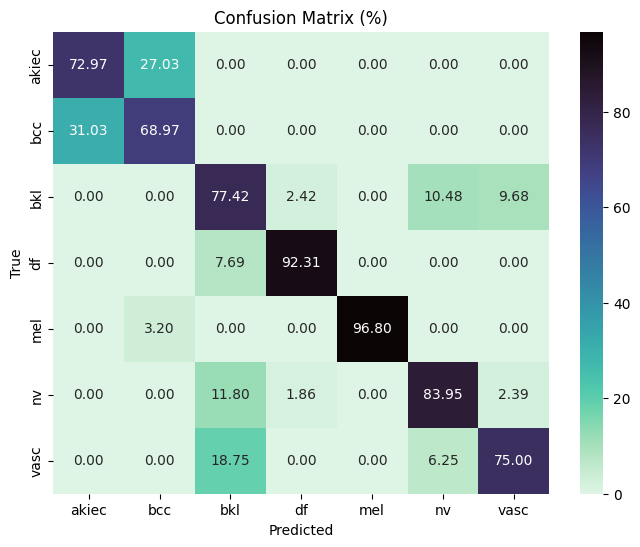

In [ ]:
evaluate_classification_report_with_matrix(ensemble_model_2, [X_val_tabular, X_val_image_10],y_val_categorical)

79/79 [==============================] - 10s 130ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.76      0.65        82
           1       0.79      0.62      0.70       129
           2       0.52      0.83      0.64       275
           3       0.42      0.90      0.57        29
           4       0.99      0.99      0.99       278
           5       0.98      0.83      0.90      1676
           6       0.20      0.57      0.30        35

    accuracy                           0.83      2504
   macro avg       0.64      0.78      0.68      2504
weighted avg       0.89      0.83      0.85      2504



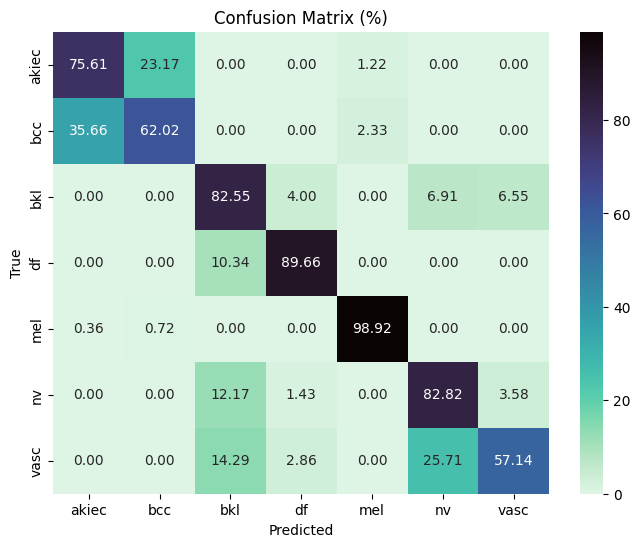

In [ ]:
evaluate_classification_report_with_matrix(ensemble_model_2, [X_test_tabular, X_test_image_10],y_test_categorical)

### 2.2.3. Observations <a class="anchor" id="sub_section_2_2_3"></a>

> Although the weighted average F1 score has decreased, there's some progress in predicting the 'vasc' class, which previously had even worse predictions. To mitigate the decrease of the weighted avg f1 score, we'll adopt a strategy used in our previous notebook. By manually adjusting the weights and fine-tuning, we aim to enhance the model's performance, reaching a balance between weighted avg f1 and the specific enhancement in the 'vasc' class prediction.

>Additionally, we plan to implement callbacks such as reducing the learning rate on plateau and incorporating early stopping. These steps should help optimize the training process, enabling us to achieve a better model that demonstrates improved overall performance.

## 2.3. Third Model <a class="anchor" id="section_2_3"></a>
---

### 2.3.1 Modeling <a class="anchor" id="sub_section_2_3_1"></a>


In this iteration of our third model, we're incorporating two vital callbacks: ReduceLROnPlateau and EarlyStopping.

ReduceLROnPlateau dynamically adjusts the learning rate during training. It monitors the validation loss, and upon detecting a plateau in improvement, it triggers a reduction in the learning rate by a factor we define, 0.2. This adjustment facilitates more precise updates to the model's parameters, optimizing the learning process.

EarlyStopping works as a preventive measure against overfitting. By monitoring the validation loss, it acts when this metric stops to improving. This intervention stops the learning process prematurely, preventing the model to learn from unecessary information that will cause overfitting.

In [ ]:
# Definition of the callback - Reduce Learning Rate on Plateau
reduce_lr = ReduceLROnPlateau(
              monitor='val_loss',  # Monitors the validation loss for changes
              factor=0.2,  # Factor by which the learning rate will be reduced (new_lr = lr * factor)
              patience=5  # Number of epochs with no improvement after which learning rate will be reduced
)

In [ ]:
early_stop = EarlyStopping(
              monitor='val_loss',  # Monitors the validation loss for changes
              patience=5,  # Number of epochs with no improvement after which training will be stopped
              mode='min'  # Direction of the monitored quantity improvement
)

In [ ]:
d_class_weights

{0: 4.384615384615385,
 1: 2.7889908256880735,
 2: 1.302857142857143,
 3: 12.493150684931507,
 4: 1.2845070422535212,
 5: 0.21333333333333335,
 6: 10.021978021978022}

In [ ]:
#Defining manual class weights
manual_weights = {0: 4.384615384615385,
 1: 3.5,
 2: 2,
 3: 13.5,
 4: 0.8,
 5: 0.21333333333333335,
 6: 11}

# Apply the manual weights
class_weights = [manual_weights[i] for i in np.unique(y_integers)]
class_weights_dict_2 = dict(enumerate(class_weights))

In [ ]:
concatenate_3 = keras.layers.concatenate([tabular_model_1_layer.output,
                        image_model_1_layer.output])

concatenate_3 = Dense(50, activation='relu', name='dense_hidden_final')(concatenate_3)

# Output layer for the ensemble model
output_3 = Dense(7, activation='softmax')(concatenate_3)  # Assuming 7 classes for output

ensemble_model_3 = keras.Model(inputs=[tabular_model_1_layer.input,
                            image_model_1_layer.input],
                    outputs=[output_3])

# Compile the ensemble model
ensemble_model_3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_3 = ensemble_model_3.fit(
    [X_train_tabular, X_train_image_10], y_train_categorical,
    epochs=50, batch_size=200,
    validation_data=([X_val_tabular, X_val_image_10], y_val_categorical)
    ,class_weight=class_weights_dict_2
    )

Epoch 1/50
32/32 [==============================] - 80s 2s/step - loss: 2.5752 - accuracy: 0.6190 - val_loss: 0.9951 - val_accuracy: 0.7178
Epoch 2/50
32/32 [==============================] - 77s 2s/step - loss: 1.5079 - accuracy: 0.7558 - val_loss: 0.7310 - val_accuracy: 0.7897
Epoch 3/50
32/32 [==============================] - 80s 3s/step - loss: 1.3916 - accuracy: 0.7608 - val_loss: 0.8316 - val_accuracy: 0.7294
Epoch 4/50
32/32 [==============================] - 76s 2s/step - loss: 1.2009 - accuracy: 0.7826 - val_loss: 0.7208 - val_accuracy: 0.8039
Epoch 5/50
32/32 [==============================] - 77s 2s/step - loss: 1.0150 - accuracy: 0.7918 - val_loss: 0.6716 - val_accuracy: 0.8234
Epoch 6/50
32/32 [==============================] - 75s 2s/step - loss: 1.0075 - accuracy: 0.7967 - val_loss: 0.6347 - val_accuracy: 0.8438
Epoch 7/50
32/32 [==============================] - 76s 2s/step - loss: 0.9685 - accuracy: 0.7998 - val_loss: 0.5840 - val_accuracy: 0.8589
Epoch 8/50
32/32 [==

### 2.3.2. Check Performance <a class="anchor" id="sub_section_2_3_2"></a>

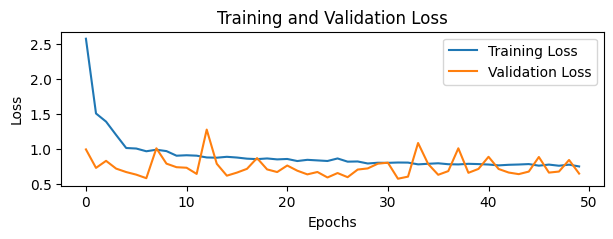

In [ ]:
plot_loss(history_3)

In [ ]:
evaluate_classification_report_with_matrix(ensemble_model_3, [X_train_tabular, X_train_image_10],y_train_categorical, matrix = False)

200/200 [==============================] - 22s 107ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.83      0.70       208
           1       0.82      0.70      0.76       327
           2       0.61      0.85      0.71       700
           3       0.40      1.00      0.57        73
           4       1.00      0.96      0.98       710
           5       0.99      0.86      0.92      4275
           6       0.33      0.99      0.50        91

    accuracy                           0.86      6384
   macro avg       0.68      0.88      0.73      6384
weighted avg       0.91      0.86      0.88      6384



36/36 [==============================] - 3s 87ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.70      0.59        37
           1       0.76      0.64      0.69        58
           2       0.55      0.77      0.65       124
           3       0.31      1.00      0.47        13
           4       1.00      0.95      0.98       125
           5       0.97      0.85      0.91       754
           6       0.39      0.88      0.54        16

    accuracy                           0.84      1127
   macro avg       0.64      0.83      0.69      1127
weighted avg       0.89      0.84      0.85      1127



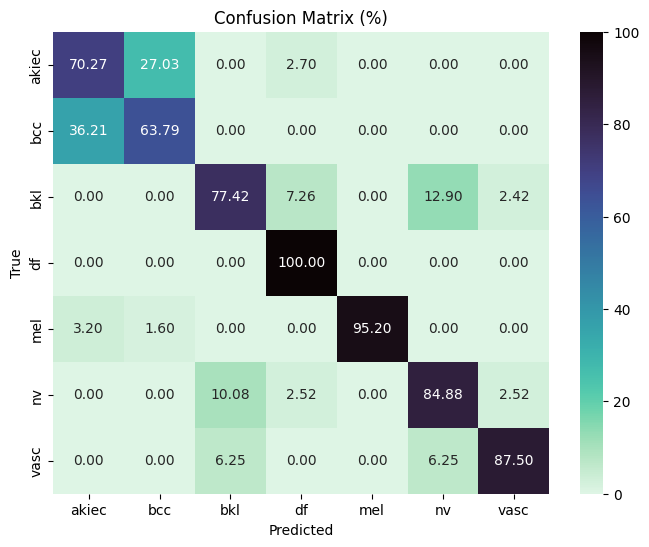

In [ ]:
evaluate_classification_report_with_matrix(ensemble_model_3, [X_val_tabular, X_val_image_10],y_val_categorical)

79/79 [==============================] - 7s 87ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.74      0.64        82
           1       0.77      0.60      0.68       129
           2       0.56      0.77      0.65       275
           3       0.30      0.90      0.45        29
           4       0.97      0.96      0.97       278
           5       0.98      0.84      0.90      1676
           6       0.19      0.60      0.29        35

    accuracy                           0.83      2504
   macro avg       0.62      0.77      0.65      2504
weighted avg       0.89      0.83      0.85      2504



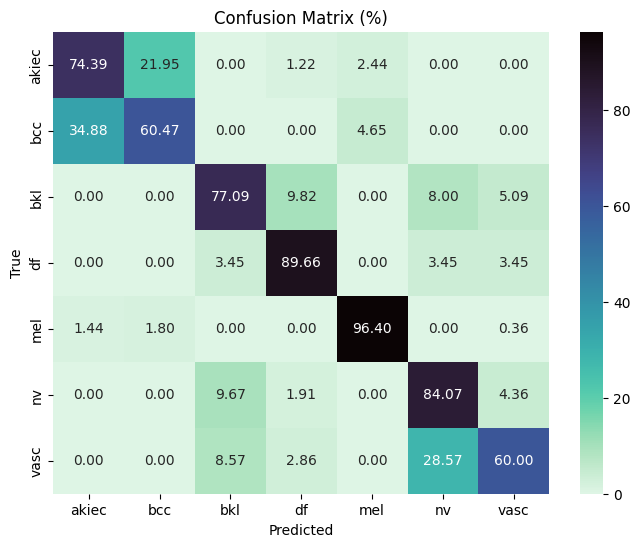

In [ ]:
evaluate_classification_report_with_matrix(ensemble_model_3, [X_test_tabular, X_test_image_10],y_test_categorical)

### 2.3.3. Observations <a class="anchor" id="sub_section_2_3_3"></a>

>Using callbacks, pairing with class weights, seem to not improve model performance. We will try updating the weights considering the classes that the third model is predicting worse than second model.

## 2.4. Fourth Model <a class="anchor" id="section_2_4"></a>
---

In this model we will update weights to achieve a better model performance.

### 2.4.1 Modeling <a class="anchor" id="sub_section_2_4_1"></a>




In [ ]:
class_weights_dict_2

{0: 4.384615384615385,
 1: 3.5,
 2: 2,
 3: 13.5,
 4: 0.8,
 5: 0.21333333333333335,
 6: 11}

In [ ]:
#Defining manual class weights #vamos aumentar as duas 1as classes
manual_weights = {0: 5,
 1: 4,
 2: 2,
 3: 14.5,
 4: 0.6,
 5: 0.21333333333333335,
 6: 12}

# Apply the manual weights
class_weights = [manual_weights[i] for i in np.unique(y_integers)]
class_weights_dict_3 = dict(enumerate(class_weights))

In [ ]:
concatenate_4 = keras.layers.concatenate([tabular_model_1_layer.output,
                        image_model_1_layer.output])

concatenate_4 = Dense(50, activation='relu', name='dense_hidden_final')(concatenate_4)

# Output layer for the ensemble model
output_4 = Dense(7, activation='softmax')(concatenate_4)  # Assuming 7 classes for output

ensemble_model_4 = keras.Model(inputs=[tabular_model_1_layer.input,
                            image_model_1_layer.input],
                    outputs=[output_4])

# Compile the ensemble model
ensemble_model_4.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_4 = ensemble_model_4.fit(
    [X_train_tabular, X_train_image_10],y_train_categorical,
    epochs=50,
    batch_size=100,
    validation_data=([X_val_tabular, X_val_image_10], y_val_categorical),
    class_weight = class_weights_dict_3,
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/50
64/64 [==============================] - 78s 1s/step - loss: 1.4341 - accuracy: 0.7246 - val_loss: 0.8590 - val_accuracy: 0.7542 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 80s 1s/step - loss: 0.9882 - accuracy: 0.8026 - val_loss: 0.7072 - val_accuracy: 0.7915 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 77s 1s/step - loss: 0.8181 - accuracy: 0.8098 - val_loss: 0.7663 - val_accuracy: 0.7791 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 79s 1s/step - loss: 0.8034 - accuracy: 0.8148 - val_loss: 0.7383 - val_accuracy: 0.7808 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - 79s 1s/step - loss: 0.7543 - accuracy: 0.8185 - val_loss: 0.6319 - val_accuracy: 0.8110 - lr: 0.0010
Epoch 6/50
64/64 [==============================] - 78s 1s/step - loss: 0.7900 - accuracy: 0.8246 - val_loss: 0.6588 - val_accuracy: 0.8048 - lr: 0.0010
Epoch 7/50
64/64 [==============================] - 77s 1s/step - loss: 0.7750 - a

### 2.4.2 Check performance <a class="anchor" id="sub_section_2_4_2"></a>


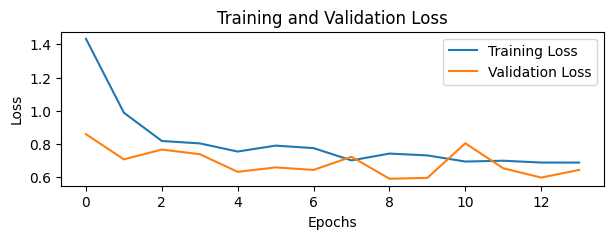

In [ ]:
plot_loss(history_4)

In [ ]:
evaluate_classification_report_with_matrix(ensemble_model_4, [X_train_tabular, X_train_image_10],y_train_categorical, matrix = False)

200/200 [==============================] - 20s 100ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.73      0.65       208
           1       0.66      0.77      0.71       327
           2       0.53      0.84      0.65       700
           3       0.25      1.00      0.40        73
           4       1.00      0.85      0.92       710
           5       0.99      0.83      0.90      4275
           6       0.45      0.93      0.61        91

    accuracy                           0.83      6384
   macro avg       0.64      0.85      0.69      6384
weighted avg       0.90      0.83      0.85      6384



36/36 [==============================] - 4s 101ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.62      0.57        37
           1       0.64      0.76      0.69        58
           2       0.51      0.77      0.61       124
           3       0.21      1.00      0.35        13
           4       0.99      0.85      0.91       125
           5       0.98      0.82      0.89       754
           6       0.52      0.94      0.67        16

    accuracy                           0.81      1127
   macro avg       0.63      0.82      0.67      1127
weighted avg       0.88      0.81      0.84      1127



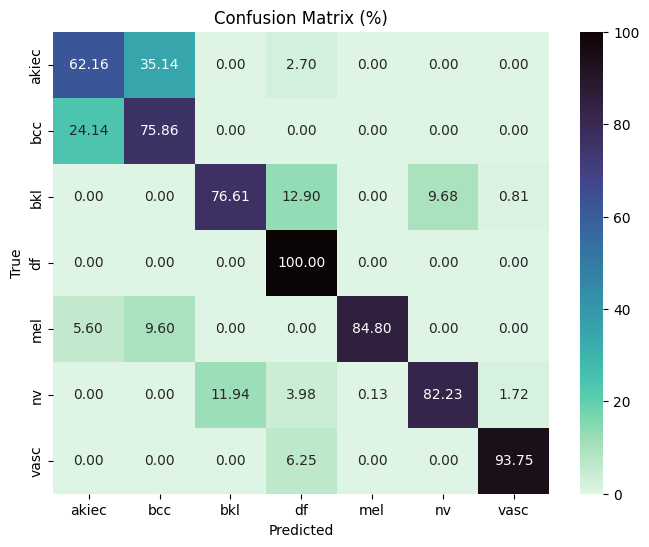

In [ ]:
evaluate_classification_report_with_matrix(ensemble_model_4, [X_val_tabular, X_val_image_10],y_val_categorical)

79/79 [==============================] - 7s 89ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.63      0.57        82
           1       0.67      0.73      0.70       129
           2       0.51      0.78      0.61       275
           3       0.21      1.00      0.35        29
           4       0.99      0.88      0.94       278
           5       0.98      0.81      0.89      1676
           6       0.35      0.71      0.47        35

    accuracy                           0.81      2504
   macro avg       0.60      0.79      0.65      2504
weighted avg       0.88      0.81      0.83      2504



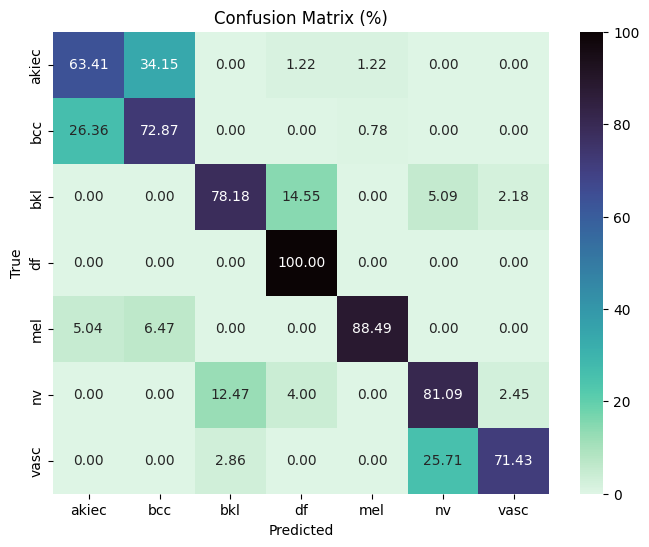

In [ ]:
evaluate_classification_report_with_matrix(ensemble_model_4, [X_test_tabular, X_test_image_10],y_test_categorical)

### 2.4.3 Observations <a class="anchor" id="sub_section_2_4_3"></a>

By the tunining we did in class weights, we could improve the predictions in  class 'vasc'. On the other hand, the predictions in most of the remaining classes fell down a bit, causing a decreasing in weighted f1 score. Later, we will compare the results of each created model and determine the model with the best overall performance.

#3.Comparing the Best Models <a class="anchor" id="section_4"></a>

Here we compare the performance of each created model to determine which is the better.

In [ ]:

f1_train_1, f1_val_1, f1_test_1 = get_f1_model(ensemble_model, [X_train_tabular, X_train_image_10],
                                              [X_val_tabular, X_val_image_10],
                                              [X_test_tabular ,X_test_image_10],
                                               y_train_categorical, y_val_categorical, y_test_categorical)
f1_train_2, f1_val_2, f1_test_2 = get_f1_model(ensemble_model_2, [X_train_tabular, X_train_image_10],
                                              [X_val_tabular, X_val_image_10],
                                              [X_test_tabular ,X_test_image_10],
                                               y_train_categorical, y_val_categorical, y_test_categorical)
f1_train_3, f1_val_3, f1_test_3 = get_f1_model(ensemble_model_3, [X_train_tabular, X_train_image_10],
                                              [X_val_tabular, X_val_image_10],
                                              [X_test_tabular ,X_test_image_10],
                                               y_train_categorical, y_val_categorical, y_test_categorical)
f1_train_4, f1_val_4, f1_test_4 = get_f1_model(ensemble_model_4, [X_train_tabular, X_train_image_10],
                                              [X_val_tabular, X_val_image_10],
                                              [X_test_tabular ,X_test_image_10],
                                               y_train_categorical, y_val_categorical, y_test_categorical)


f1_scores_notebook_4 = pd.DataFrame({
    'Model Name': ['Model 1', 'Model 2', 'Model 3', 'Model 4'],
    'Train F1 Score': [f1_train_1, f1_train_2, f1_train_3, f1_train_4],
    'Validation F1 Score': [f1_val_1, f1_val_2, f1_val_3, f1_val_4],
    'Test F1 Score': [f1_test_1, f1_test_2, f1_test_3, f1_val_4]
})
f1_scores_notebook_4

79/79 [==============================] - 10s 132ms/step


,Model Name,Train F1 Score,Validation F1 Score,Test F1 Score
0,Model 1,0.750256,0.733745,0.738690
1,Model 2,0.701028,0.693272,0.692384
2,Model 3,0.866159,0.839486,0.839731
3,Model 4,0.848166,0.835386,0.835386


The table above compares the weighted f1 scores of each model in train, validation and test set. We can clearly analyze that the best models are 3 and 4 since they are the ones that predicts better on test set. Between models 3 and 4, we consider 4 as the best because model 3 presents a bit of overfitting.

With this, we will also compare the results of the best model of this notebook (model 4) with the best CNN model of notebook 2 and the best NN model of notebook 3.

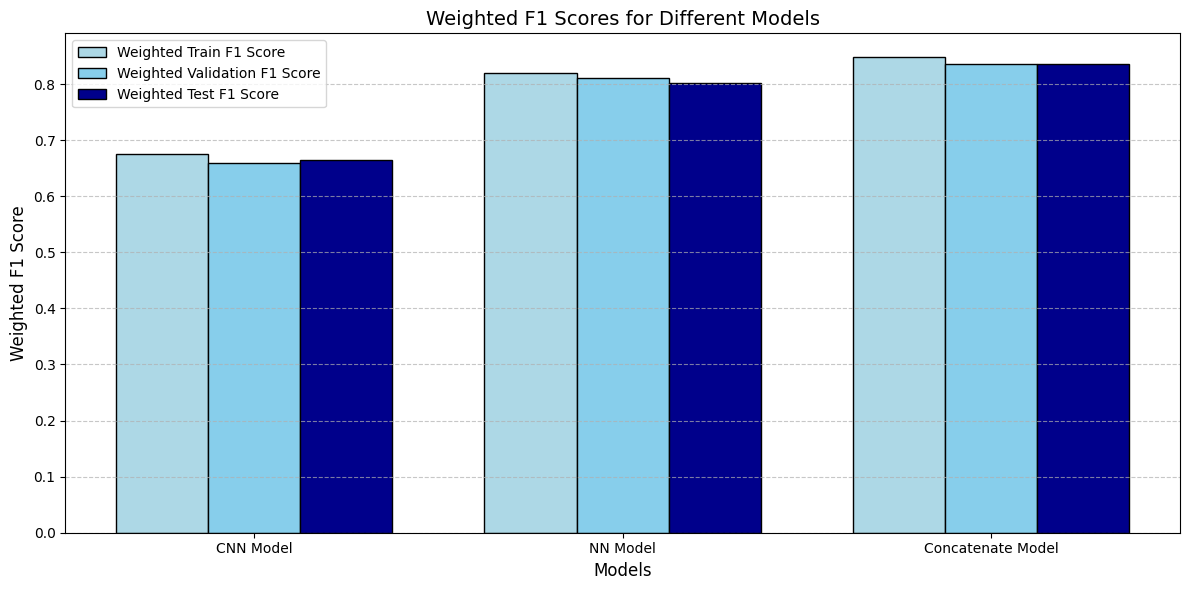

In [ ]:
# Import f1 scores of best models in notebook 2 and 3
f1_scores_notebook_2 = pd.read_csv('/content/drive/MyDrive/Deep Learning/Project - 80%/f1_scores_notebook_2.csv')
f1_scores_notebook_3 = pd.read_csv('/content/drive/MyDrive/Deep Learning/Project - 80%/f1_scores_notebook_3.csv')

# Assess f1 score if Model 4
f1_scores_model_4 = f1_scores_notebook_4[f1_scores_notebook_4['Model Name'] == 'Model 4']

# Combine F1 scores into a single dataframe
combined_f1_scores = pd.concat([f1_scores_notebook_2, f1_scores_notebook_3, f1_scores_model_4])

# Resetting the index of the combined_f1_scores DataFrame
combined_f1_scores = combined_f1_scores.reset_index(drop=True)

combined_f1_scores.loc[0, 'Model Name'] = 'CNN Model'
combined_f1_scores.loc[1, 'Model Name'] = 'NN Model'
combined_f1_scores.loc[2, 'Model Name'] = 'Concatenate Model'

# Set the number of models and bar width
num_models = len(combined_f1_scores)
bar_width = 0.25

# Create the bar positions for each group
r1 = range(num_models)
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bar plot
plt.figure(figsize=(12, 6))

plt.bar(r1, combined_f1_scores['Train F1 Score'], color='lightblue', edgecolor='black', width=bar_width, label='Weighted Train F1 Score')
plt.bar(r2, combined_f1_scores['Validation F1 Score'], color='skyblue', edgecolor='black', width=bar_width, label='Weighted Validation F1 Score')
plt.bar(r3, combined_f1_scores['Test F1 Score'], color='darkblue', edgecolor='black', width=bar_width, label='Weighted Test F1 Score')

plt.xlabel('Models', fontsize=12)
plt.ylabel('Weighted F1 Score', fontsize=12)
plt.title('Weighted F1 Scores for Different Models', fontsize=14)
plt.xticks([r + bar_width for r in range(num_models)], combined_f1_scores['Model Name'], ha='center', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

By analyzing the plot, it's evident that the concatenation of the CNN model with the NN model resulted in an improved model. This process of concatenation proved to be worthwhile based on the observed outcome.

Below we have the architechture of the best model we could define, the concatenate model (model 4 in this notebook).


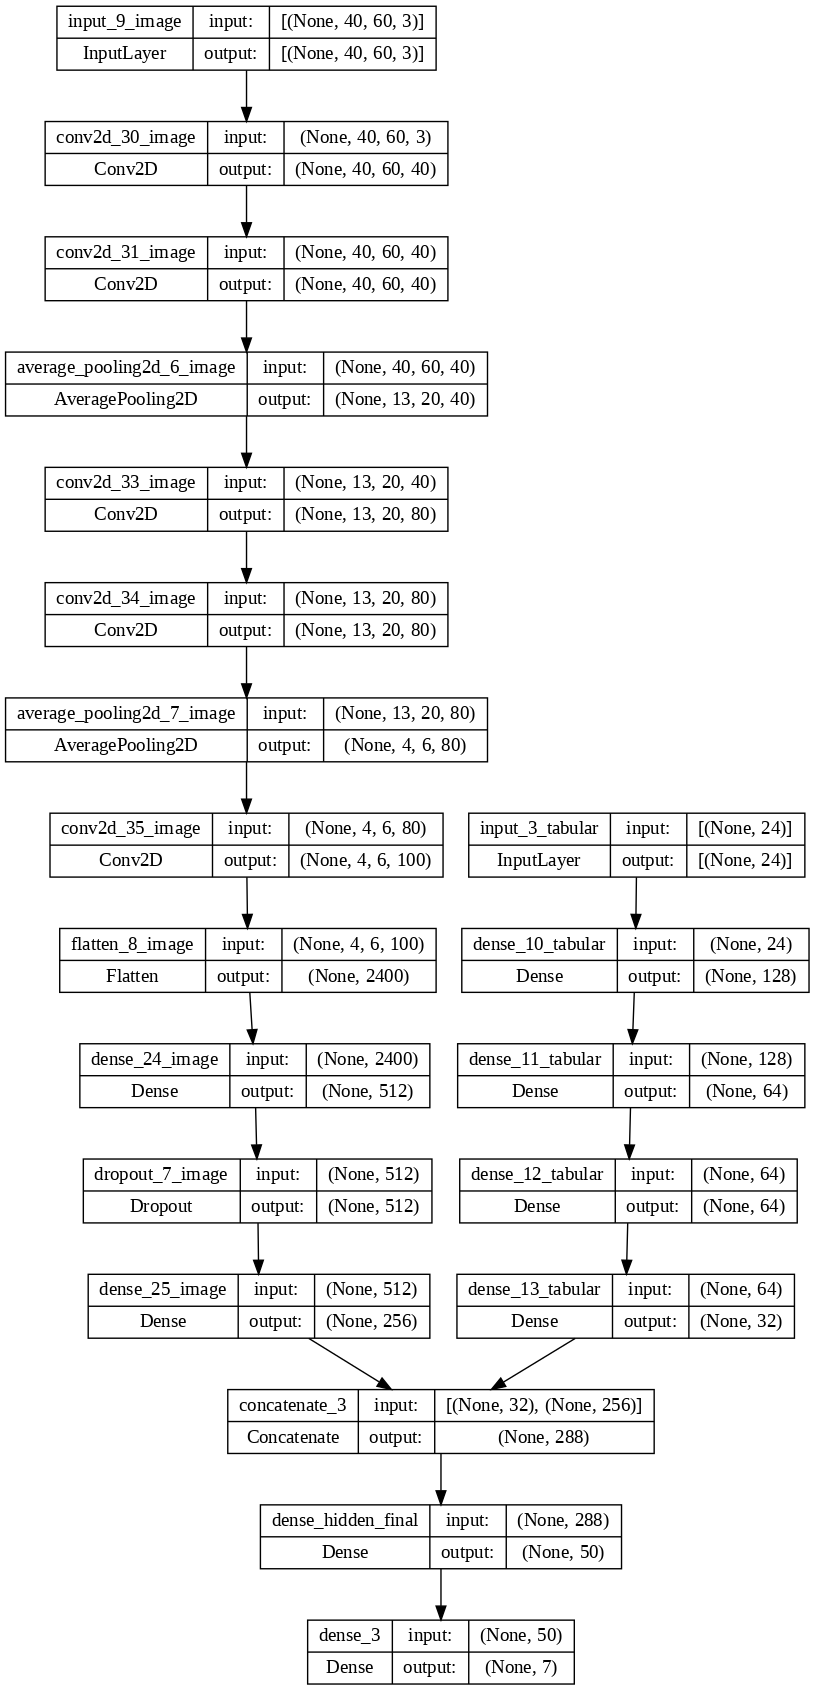

In [ ]:
# # Save the visualization of the model
plot_model(ensemble_model_4, to_file='model.png', show_shapes=True, show_layer_names=True,dpi=100)